# APPLICATION OF MACHINE LEARNING TO HIGH FREQUENCY TRADING OF STOCKS

# PROJECT OBJECTIVES:

1) Create a stock market predictor:
    - Design a function to scrape stock market data from Yahoo Finance 
    - Obtain High Frequency Minute Data for any stock in the Dow jones Industrial Average(DJIA)
    - Compute some technical inidcators as features for the stock predictor
    - Use the following Machine learning algorithms: LogisticRegression, Linear DiscriminantAnalysis, KNeighbors   Classifier,         DecisionTree Classifier, GaussianNB, SVC, Random ForestClassifier, XGBClassifier, etc, for the prediction of stock market       movements
    - compute the performance of the Machine Learning Algorithms and choose the best learner
    - Use the best learner to predict the stock price movements
    
2) Create a trading strategy based on the predicted market prices movement and backtest the strategy

3) Measure the performance of the strategy against the non machine learning Buy and Hold strategy.

# IMPORT LIABRARIES NEEDDED FOR THE PROJECT

In [2]:
import csv
import arrow
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from Compute_KPI_OutputClass import Output
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.font_manager as font_manager
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import fix_yahoo_finance as yf
from pandas_datareader import data as pdr
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA
cntk.tests.test_utils.set_device_from_pytest_env()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

# Yahoo Finance function to download High Frequency (minute) Data

This is a Function to scrape intraday High frequency Data from Yahoo Finance. The Function takes as arguments: 
- the stock symbol ('IBM'), 
- data_range in days('7d') The maximum is 7days, 
- data_interval('1m') in minutes, 5minutes, 30 minutes, 60minutes and 1day.

In [3]:
def get_quote_data(symbol, data_range, data_interval):
    #symbol, data_range, data_interval
    #symbol=raw_input('Please enter a valid ticker enclose with "" :')
    #data_range = raw_input('Please enter date range in days(Maximum: 7d) enclose with "" :')
    #data_interval = raw_input('Please enter time interval in minutes enclose with "" (EX. "1m") :')                     
    res = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?range={data_range}&interval={data_interval}'.format(**locals()))
    data = res.json()
    body = data['chart']['result'][0]    
    dt = datetime.datetime
    dt = pd.Series(map(lambda x: arrow.get(x).to('Asia/Calcutta').datetime.replace(tzinfo=None), body['timestamp']), name='Datetime')
    df = pd.DataFrame(body['indicators']['quote'][0], index=dt)
    dg = pd.DataFrame(body['timestamp'])    
    df = df.loc[:, ('open', 'high', 'low', 'close', 'volume')]
    df.dropna(inplace=True)     #removing NaN rows
    df.columns = ['OPEN', 'HIGH','LOW','CLOSE','VOLUME']    #Renaming columns in pandas
    return df

# Create a function to compute Technical Indicators based on the data

In [4]:
def process_data(data):
    data['BB_5']=ta.bollinger_mavg(data['CLOSE'],5) #bollinger_moving average 5 trading periods
    data['BB_10']=ta.bollinger_mavg(data['CLOSE'],10) #bollinger_moving average 10 trading periods
    data['BB_20']=ta.bollinger_mavg(data['CLOSE'],20) # bollinger_moving average 20 periods
    data['ADX']=ta.adx(data['HIGH'], data['LOW'], data['CLOSE'], 14) #Average Directional Index
    data['ATR']=ta.average_true_range(data['HIGH'], data['LOW'], data['CLOSE'], 14) #Average True Range
    data['CCI']=ta.cci(data['HIGH'], data['LOW'], data['CLOSE'], 14) #Commodity Channel Index
    data['DCH']=ta.donchian_channel_hband(data['CLOSE']) #Donchian Channel High Band
    data['DCL']=ta.donchian_channel_lband(data['CLOSE']) #Donchian Channel Low Band
    data['DPO']=ta.dpo(data['CLOSE']) #Detrend Price Oscilator
    data['EMAf']=ta.ema_fast(data['CLOSE']) #Expornential Moving Average fast
    data['EMAs']=ta.ema_slow(data['CLOSE']) #Expornential Moving Average slow
    data['FI']=ta.force_index(data['CLOSE'], data['VOLUME']) # Force Index(reveals the value of a trend)
    data['ICHa']=ta.ichimoku_a(data['HIGH'], data['LOW']) #Ichimoku A
    data['ICHb']=ta.ichimoku_b(data['HIGH'], data['LOW']) #Ichimoku B
    data['KC']=ta.keltner_channel_central(data['HIGH'], data['LOW'], data['CLOSE']) #Keltner channel(KC) Central
    data['KST']=ta.kst(data['CLOSE']) #KST Oscillator (KST) identify major stock market cycle junctures
    data['MACD']=ta.macd(data['CLOSE']) # Moving Average convergence divergence
    data['OBV']=ta.on_balance_volume_mean(data['CLOSE'], data['VOLUME']) # on_balance_volume_mean
    data['RSI']=ta.rsi(data['CLOSE']) # Relative Strength Index (RSI)
    data['TRIX']=ta.trix(data['CLOSE']) #Shows the percent rate of change of a triple exponentially smoothed moving average
    data['TSI']=ta.tsi(data['CLOSE']) #True strength index (TSI)
    data['ROC1']=(data['CLOSE']-data['OPEN'])/data['OPEN']
    data['RET']=data['CLOSE'].pct_change()
    data['y'] = np.where(data['OPEN'] <= data['CLOSE'],1,-1)
    data=data.dropna()
    return data

# Create a Function to perform features importance using a correlation matrix
- This function takes a dataframe generated from Scraped financial data and technical indicators calculated.

In [5]:
def feature_imp(data):
    corrmat=data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sb.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
    plt.title('Correlation between different fearures and target')
    plt.show()
    return 

# Function to model the data using 8 Machine learning classification algorithms in sklearn.

- Scale, transform and partition the data into training (80%) and test (20%) sets

- This function takes the downloaded data and technical indicators as features, train the models using the training set, predict new data points showing if the minutes stock price is increasing (1) or decreasing (-1). A performance matrix showing accuracy score of the various models is generated and the best model is picked to predict stock movements in High frequency trading.

In [6]:
def modeling(data):
    Xi = data.drop(['y'], axis=1)
    scaler=StandardScaler().fit(Xi) # Use the standard scaler function from scikit learn
    Xs = scaler.transform(Xi) 
    #pca = PCA(n_components=3)
    #pca.fit(Xi)
    #X = pca.transform(Xi)
    X=Xs
    Y=data['y']
    global xTrain
    global xTest 
    global yTrain 
    global yTest
    xTrain, xTest, yTrain, yTest = train_test_split(X,Y, test_size = 0.2, random_state = 0)
    models = []
    models.append(('LR' , LogisticRegression()))
    models.append(('LDA' , LinearDiscriminantAnalysis()))
    models.append(('KNN' , KNeighborsClassifier()))
    models.append(('CART' , DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)))
    models.append(('NB' , GaussianNB()))
    models.append(('SVM' , SVC()))
    models.append(('RF' , RandomForestClassifier(n_estimators=60)))
    models.append(('XGBoost', XGBClassifier(gamma=0.0, n_estimators=60,base_score=0.7, max_depth=3, objective = "binary:logistic", colsample_bytree=1,learning_rate=0.01)))
    
    results = []
    names = []
    '''
    for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) '''
    for name, model in models:
        clf = model
        clf.fit(xTrain, yTrain)
        y_pred = clf.predict(xTest)
        accu_score = accuracy_score(yTest, y_pred)
        results.append([name, accu_score])
        #print(name + ": " + str(accu_score))
    re=pd.DataFrame(results, columns=['Model', 'Acuracy_Score'])
    re.set_index(['Model'])
    return re

# FUNCTION TO PREDICT STOCK MOVEMENT USING DECISION TREE CLASSIFIER
- This function takes as arguments xTrain, yTrain, xTest and returns predicted stock movement and a classification report.

In [7]:
def predstockmvt(xTrain, yTrain, xTest):
    clf1 = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)
    clf1=clf1.fit(xTrain, yTrain)
    yPreddt = clf1.predict(xTest)
    report=classification_report(yTest,yPreddt)
    print(report)
    return

# Function to backtest the strategy
- If the Model predicts an increase in price; we buy at the Open
- If the model predicts a decrease in stock price, we sell the stock
- The asumption for this strategy is that short selling is allowwed, No transaction cost and there is equal investment.

In [8]:
def backtest(data):
    trade_data=data.iloc[len(xTrain):]
    trade_data['signal']=0
    trade_data.loc[trade_data['y']>=1,'signal']=1
    trade_data.loc[trade_data['y']<=-1,'signal']=0
    trade_data['Strategy_return']=trade_data['signal']*trade_data['ROC1']
    trade_data['Market_return']=trade_data['ROC1']
    global perf
    perf=trade_data[['Market_return', 'Strategy_return']].cumsum()
    #trade_data[['Market_return'], ['Strategy_return']]
    plt.figure(figsize=(10,10))
    perf.plot()
    plt.title('Evolution of Cumulative Returns')
    plt.show()
    return

# IMPLEMENT FUNCTIONS ON A CASE STUDY(IBM)

# Apply the function to download minute data from Yahoo for the last seven days

In [9]:
datas=get_quote_data('IBM', '7d', '1m')
print(datas.head())

                           OPEN        HIGH         LOW       CLOSE   VOLUME
Datetime                                                                    
2019-02-28 20:00:00  139.000000  139.000000  138.710007  138.710007  76041.0
2019-02-28 20:01:00  138.729996  138.729996  138.607605  138.607605  13603.0
2019-02-28 20:02:00  138.570007  138.570007  138.500000  138.500000  10188.0
2019-02-28 20:03:00  138.410004  138.479996  138.339996  138.339996  12170.0
2019-02-28 20:04:00  138.389999  138.389999  138.240005  138.307800  20551.0


# Apply the function to compute all relevant technical Indicators

In [10]:
se=process_data(datas)
print(se.head())

                           OPEN        HIGH         LOW       CLOSE  VOLUME  \
Datetime                                                                      
2019-02-28 21:17:00  138.130005  138.139999  138.130005  138.139999  5360.0   
2019-02-28 21:18:00  138.080002  138.169998  138.080002  138.169998  4126.0   
2019-02-28 21:19:00  138.139999  138.139999  138.139999  138.139999  1595.0   
2019-02-28 21:20:00  138.070007  138.070007  138.009995  138.009995  8121.0   
2019-02-28 21:21:00  137.979996  137.979996  137.970001  137.970001  4832.0   

                           BB_5       BB_10       BB_20        ADX       ATR  \
Datetime                                                                       
2019-02-28 21:17:00  138.169998  138.169998  138.154219  22.156988  0.047721   
2019-02-28 21:18:00  138.163998  138.169998  138.164219  23.396859  0.050552   
2019-02-28 21:19:00  138.156000  138.167998  138.166219  24.552249  0.049176   
2019-02-28 21:20:00  138.125998  138.151997  1

# We'll then conduct features engineering to select the best features to be fitted into the Machine learning algorithms in order to predict the stock market price movemenets using the function feature_imp() above.

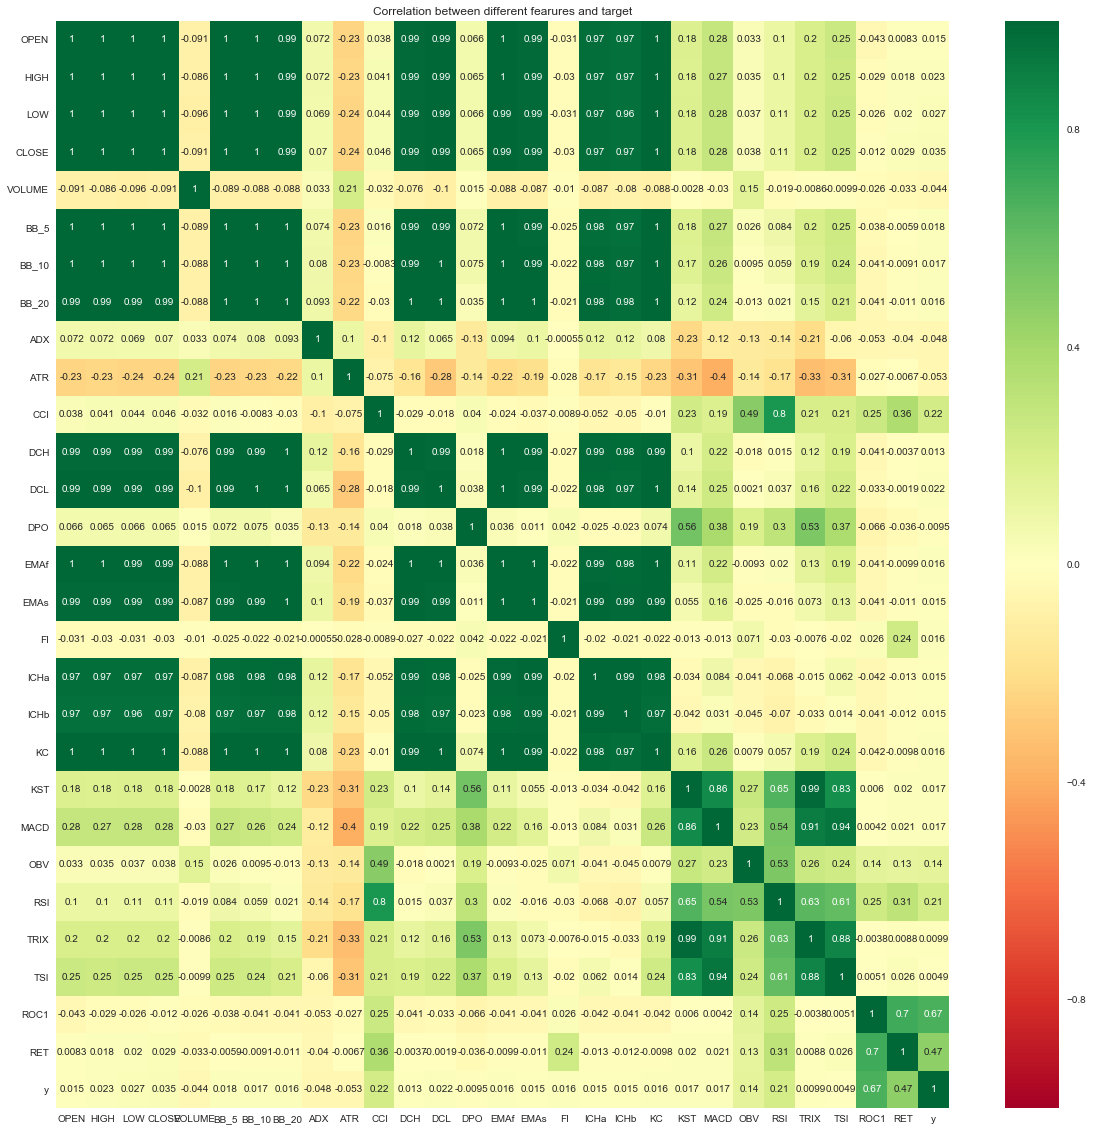

In [11]:
feature_imp(se)

The result show a heatmap of relationships of one feature to another. As seen above; most of the features are related to one another and to the target variable

From the heatmap above it is clear that all the features contribute to the prediction of the target variable (y). The most outstanding features are: The rate of change (ROC), returns (RET), Relative Strength Index (RSI), Commodity Channel Index (CCI)

# Model the data using eight machine learning algorithms and display the performance report and Test the Hypothesis

In [18]:
print('The shape of the Dataset is:')
print(se.shape)

(2631, 29)

- The data set consists of 2631 rows with 28 features and one target variable 
- The target variable represents movement in stock prices denoted by '1' when the stock price increase and -1 when it decrease
- The model trains the dataset with 80% of the data using the features and the targets
- The models then use features of the test data(20%) to classify the results to '1' if they predict an increase in stock price and to '-1' if they predict a decrease in stock price.

In [12]:
print(modeling(se))

C:\Users\Admin\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Admin\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Model,Acuracy_Score
0,LR,0.994307
1,LDA,0.888046
2,KNN,0.827324
3,CART,1.000000
4,NB,0.810247
5,SVM,0.954459
6,RF,1.000000
7,XGBoost,1.000000


- From the analyses all the models achieve considerable level of performance in predicting stock movements. Outstanding models include: Decision Trees(CART), Random Forest(RF), and Extreme Gradient Boosting(XGBoost).

- This greatly justify the hypothesis that Machine Learning algorthms could be used to predict stock movements in High Frequency Trading setting.

- Decision Trees Classifier is thus retained to predict stock movements for the purpose of this project.

# Predict Stock Movements using Decision Trees and present the performance matric

In [13]:
Y=predstockmvt(xTrain, yTrain, xTest)
Y

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00       245
          1       1.00      1.00      1.00       282

avg / total       1.00      1.00      1.00       527



# Compare number of predicted with actual results

In [14]:
print(yTest.value_counts())
print('This justifies the prediction above.')

 1    282
-1    245
Name: y, dtype: int64
This justifies the prediction above.


# Backtest the predicted results using the backtest function and represent the result in a graph

C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Admin\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<Figure size 720x720 with 0 Axes>

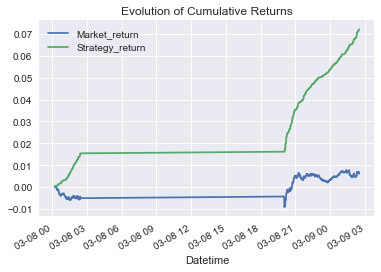

In [15]:
backtest(se)

In [16]:
print('Performance of the Trading strategy(Assume equal Investment')
Risk_return=Output(perf)
print(Risk_return.generate_output())

Performance of the Trading strategy(Assume equal Investment


C:\Users\Admin\Anaconda2\lib\site-packages\pandas\core\series.py:1828: RuntimeWarning: invalid value encountered in rint
  result = com._values_from_object(self).round(decimals)


,Market_return,Strategy_return
Annualized Return,0.5121,9.5550
Annualized Std Dev,0.0696,0.3508
Avg Loss Return,-0.0038,NaN
Avg Win Return,0.0049,0.0379
Gain to Pain Ratio,2.0517,NaN
Lake Ratio,0.1407,0.0000
Loss Rate,0.3245,0.0000
Max Drawdown,-0.4824,0.0000
Sharpe Ratio,7.3529,27.2359
Trade Expectancy,0.0045,NaN


# SWOT ANALYSIS

# Strengths:
- Ability the generate several trades(527) in a day using simple machine learning strategy on High Frequency data
- The system can make use of trading opportunities immidietely as they present themselves in minutes.
- Ability to generate superior returns about 10 times higher than the market 
- Simple trading strategy based on accurate prediction of market movements using simple Machine Learning Algorithms
- High Win rate of 100%  with a win return per trade of 3%
- Increased anualised sharp ratio leading to high alpha generation.
- it ensures "best execution" of trades because and it minimizes the human element in trading decision making.
- Improves liquidity with lesser Drawdowns
- The sytem also reduces transactions costs significantly due to limited human interferences 
- The sytem performs significantly well on all the stocks in Dow Jones Industrial Average index and even on stocks out of the index

# Weaknesses:
- High increase in volatility( from 6% to 35%) due to large number of trades within a limited time frame.
- The system is not very interative to the user, as the user has to enter functions to generate the data, model and return outputs. opportunities exiists to make the system fully functional and interactive
- Require huge amount of time in designing the functions and optimising the algorithms.
- Strict monitoring of the system to avoid to system overuns and failures
- Deficulties in applying the system to several(morethan one) stock at a time due to deficulties in obtaining free High frequency data
- Transaction cost and other expenses are not factored into the system further development will include the modules
- Market Sentiments indicators were not included as part of the features set. These indicators could greatly influence the market returns.

# Opportunities:
- Availbility of performant computers, softwares and internet facilities which facilitates the implementation of High Frequency algorithmic trading
- Availability of programming, application development tools and modules like python, pandas, scikit learn, statsmodels, CNTK, matplotlib, Technical analyses library, etc to facilitate the designing of this project
- Availability of huge trading opportunities in minutes to take advantage of.
- Availability of financial markets with regulatory mechanisms(Securities Exchange Commision) to curtail the effects and imperfections of high frequency algorithmic trading.

# Threats:
- Unavailability of free quality High Frequency data for longer period of times. For this project we could only get one minute data for the last seven trading days.
- High Volatility could lead to frequent stock market breakdowns and imperfections
- It requires high testing, monitoring  and regulation as error in the system could lead to high lost of capital
- It requires huge investment in the system and trading
- High cost of acquisition of data for the trading sytem on longer time frames.

# Further Research:
- Continue and build a fully functional and interactive trading system with multiple stcoks and portfolios at a time.
- Build a database of historical high frquency stock data for major stock exchanges in the world and populate it with Data for the last five years of trading ( I intend to purchase the data). 
- Add other technical indicators to the system and enable the system to trade based on technical indicators and machine learning at a time.
- Add other Machine Learning, Learning and Reinforcement Learning algorithms to trade combination of technical indicators and machine learning on huge High frequency stock data
- Add options, commodities, Forex and cryto data on the system for effective High frequency algorithm trading 
- Develop and add other backtest functions based on technical indicators